# 2D Convolutional Neural Networks
In this case study, we will train a custom 2D CNN model with Lidar images. We will also study how to use Pytorch and torchvision, the image subpackage from torch.

The task is to predict the loan delinquency ratio for a specific geographic area. Let's begin by importing the Python packages needed for this analysis.

In [1]:
!pip install torchcam livelossplot

In [2]:
# Basic packages
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from IPython.display import Image as DisplayImage

## Downloading Loan and LiDAR Data

We are downloading:
- **Loan data** (CSV file)
- **LiDAR images** (ZIP files) collected based on:
  - **3-digit US ZIP codes**
  - **Metropolitan Statistical Areas (MSA)**

This dataset will be used for further analysis and modeling.

In [2]:
!gdown --fuzzy 'https://drive.google.com/file/d/1uDziz14xOgUTmW2DxPufuQMATL6O8Ial/view?usp=sharing'

Downloading...
From (original): https://drive.google.com/uc?id=1uDziz14xOgUTmW2DxPufuQMATL6O8Ial
From (redirected): https://drive.google.com/uc?id=1uDziz14xOgUTmW2DxPufuQMATL6O8Ial&confirm=t&uuid=b92602b7-f3b4-4b0e-a424-51ce7544db5b
To: /content/usgs_lidar.zip
100% 80.7M/80.7M [00:00<00:00, 113MB/s]


In [3]:
!gdown --fuzzy 'https://drive.google.com/file/d/1-YWiPPtLQmkuWjcZcckM9vgv4Fsm68Je/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1-YWiPPtLQmkuWjcZcckM9vgv4Fsm68Je
To: /content/sampled_data.csv
100% 33.8k/33.8k [00:00<00:00, 61.2MB/s]


## Unzipping LiDAR Data
All ZIP files will be **automatically extracted** into the `usgs_lidar/` folder.  

In [4]:
!unzip usgs_lidar.zip -d usgs_lidar

Archive:  usgs_lidar.zip
  inflating: usgs_lidar/10180_796_USGS_13_n33w101_20191031.jpg  
  inflating: usgs_lidar/10420_443_USGS_13_n41w082_20230911.jpg  
  inflating: usgs_lidar/10540_973_USGS_13_n45w122_20220426.jpg  
  inflating: usgs_lidar/10740_870_USGS_13_n36w106_20241210.jpg  
  inflating: usgs_lidar/10740_871_USGS_13_n35w108_20240416.jpg  
  inflating: usgs_lidar/10780_713_USGS_13_n31w093_20240207.jpg  
  inflating: usgs_lidar/11020_166_USGS_13_n41w079_20220429.jpg  
  inflating: usgs_lidar/11100_790_USGS_13_n35w104_20210624.jpg  
  inflating: usgs_lidar/11100_791_USGS_13_n36w103_20190916.jpg  
  inflating: usgs_lidar/11244_928_USGS_13_n34w119_20190917.jpg  
  inflating: usgs_lidar/11260_995_USGS_13_n64w154_20190206.jpg  
  inflating: usgs_lidar/11700_288_USGS_13_n36w083_20220512.jpg  
  inflating: usgs_lidar/12060_302_USGS_13_n33w084_20230215.jpg  
  inflating: usgs_lidar/12060_303_USGS_13_n34w085_20230215.jpg  
  inflating: usgs_lidar/12060_306_USGS_13_n34w084_20230215.jpg  


Let's see an example of LiDAR image

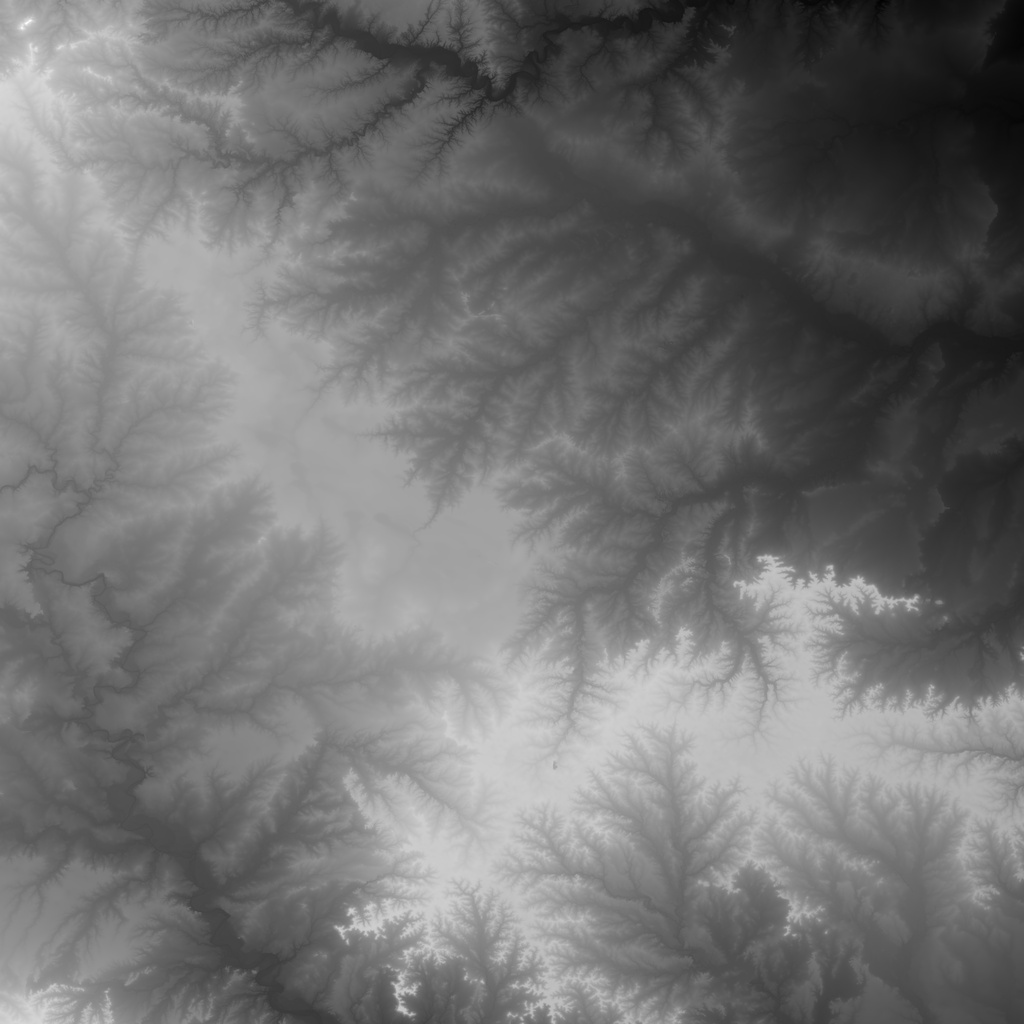

In [3]:
DisplayImage(filename='usgs_lidar/10180_796_USGS_13_n33w101_20191031.jpg')

This is one of the layers you can use from LiDAR images. This one represents different densities in the sector, including bodies of water.

Let's load the Loan Data in CSV format, using Pandas. The data comes from the [Single Family Loan Dataset](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset), from Freddie Mac.

In [4]:
df = pd.read_csv('sampled_data.csv', dtype=str)
df['loan_delinquency'] = df['loan_delinquency'].astype(float)
df['LiDAR_File'] = df['LiDAR_File'].astype(str).str.replace("\\", "/") ## following linux path
df.head()

,MSA,ZIP3,loan_delinquency,LiDAR_File
0,10180,796,0.011628,usgs_lidar/10180_796_USGS_13_n33w101_20191031.jpg
1,10420,443,0.010554,usgs_lidar/10420_443_USGS_13_n41w082_20230911.jpg
2,10540,973,0.013793,usgs_lidar/10540_973_USGS_13_n45w122_20220426.jpg
3,10740,870,0.023392,usgs_lidar/10740_870_USGS_13_n36w106_20241210.jpg
4,10740,871,0.022329,usgs_lidar/10740_871_USGS_13_n35w108_20240416.jpg


The dataset is very simple.



After loading the dataset, we need to split it for **training, validation, and testing**.

In [5]:
temp, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(temp, test_size=0.3, random_state=42)

Finally, let's verify torch is running on GPU. The following code gets that and also allocates the device (the GPU) to a variable.

In [6]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

# Making the code device-agnostic
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The default device is set to {device}")

Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device: 0
Name of current CUDA device: Tesla T4
The default device is set to cuda


## Preparing LiDAR Image Data for Deep Learning

Before training a neural network, we need to **preprocess the LiDAR images**.  

---

### Image Transformations  
We apply the following preprocessing steps to standardize all images:

1. **Resize to (256, 256)** → Ensures all images have a fixed size.  
2.  **Convert to Tensor** → Converts images into PyTorch tensors (`C x H x W` format).  
3.  **Normalize (Mean=0.5, Std=0.5)** → Centers pixel values around zero for better training stability.  

---

### Creating a Custom Dataset for LiDAR Images  
We define a `LiDARDataset` class to **load** and **process** images from a DataFrame.  
Each dataset entry contains:
-  **`LiDAR_File`** → The file path of the image.  
-  **`loan_delinquency`** → The target variable, representing the loan delinquency raio (a float between 0 and 1).  


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for CNN
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for stable training
])


class LiDARDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df.iloc[idx]["LiDAR_File"]  # Path to JPG file
        target = self.df.iloc[idx]["loan_delinquency"]  # Target

        #  Load Image using PIL
        img_pil = Image.open(file_path).convert("L")  # Convert to grayscale

        # Apply Transformations (Resize, ToTensor, Normalize)
        img_tensor = transform(img_pil)

        return img_tensor, torch.tensor(target, dtype=torch.float)

In [8]:
train_dataset = LiDARDataset(train)
val_dataset = LiDARDataset(val)
test_dataset = LiDARDataset(test)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's visualize a few examples from DataLoader

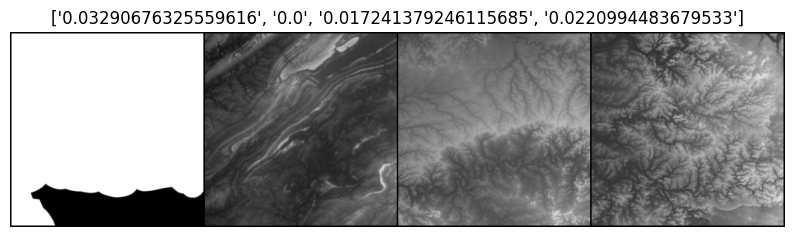

In [9]:
SEED = 20
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

def imshow(inp, title=None):
    """
    Display a single image. Supports grayscale (1-channel) and RGB (3-channel) images.
    """
    inp = inp.cpu().numpy()  # Convert tensor to NumPy
    plt.figure(figsize=(10, 10))

    if inp.shape[0] == 1:  # If 1-channel (grayscale)
        inp = inp.squeeze(0)  # Remove channel dimension
        plt.imshow(inp, cmap="gray")  # Display as grayscale
    else:  # If 3-channel (RGB)
        inp = inp.transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
        plt.imshow(inp)

    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()

def show_databatch(inputs, labels, num_images=4):
    """
    Display a batch of JPG images. Supports grayscale and RGB images.
    """
    inputs, labels = inputs.cpu(), labels.cpu()  # Move to CPU
    inputs = inputs[:num_images]  # Limit to num_images
    labels = labels[:num_images]

    # Use torchvision make_grid but handle grayscale images properly
    if inputs.shape[1] == 1:  # If grayscale images
        out = torchvision.utils.make_grid(inputs, nrow=4, normalize=True)
    else:  # If RGB images
        out = torchvision.utils.make_grid(inputs, nrow=4, normalize=True, value_range=(0, 1))

    imshow(out, title=[str(label.item()) for label in labels])

#  Get a batch of training data
inputs, labels = next(iter(train_loader))  # Fetch batch
show_databatch(inputs, labels)  # Display images

## Building a Convolutional Neural Network (CNN) for LiDAR Images

We define a **Simple CNN model** to predict the loan delinquency ratio from LiDAR images. The model performs regression, outputting a continuous value.

---

### Model Architecture  

This CNN consists of **two main parts**:
1. **Feature Extraction (Convolutional Layers)**
   - **Detects patterns** in LiDAR images (edges, textures, shapes).
   - Uses **Convolution, Batch Normalization, ReLU activation, and Max Pooling**.

2. **Regression Head (Fully Connected Layers)**
   - **Flattens** extracted features and passes them through **Dense (FC) layers**.
   - Uses **Dropout** to prevent overfitting.
   - Outputs a single continuous value representing predicted loan delinquency ratio.

---


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, input_channels=1):  # 3 for RGB, 1 for Grayscale
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 64 * 64, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
            )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

To monitor the training loop, we'll use the livelossplot package. It is a simple interface to visualize training as it happens.

Now we'll define the training loop. The following code does EPOCHS rounds of training, showing the ongoing loss. Once per epoch, liveloss is updated.

In [12]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

# Check if images are grayscale or RGB
input_channels = 1 if train_dataset[0][0].shape[0] == 1 else 3

# Move Model to GPU if Available
model = SimpleCNN(num_classes=1, input_channels=input_channels)
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Lower LR to avoid overfitting

## Training & Validation Loss Convergence

The training and validation loss curves **show convergence**, meaning the model is learning effectively.

---


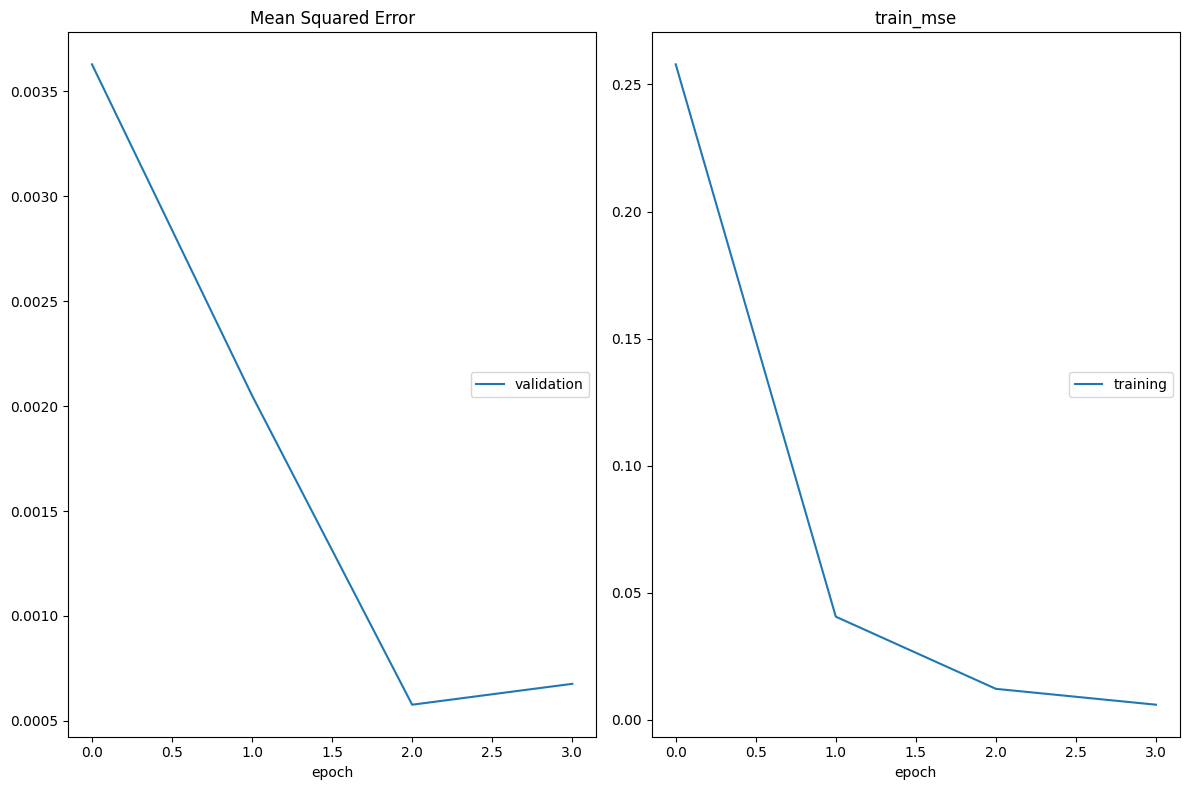

KeyboardInterrupt: 

In [16]:
# Training with Live Loss Plot
liveloss = PlotLosses(outputs=[MatplotlibPlot(figpath =f"ConvergenceSimple_{str(optimizer.param_groups[0]['lr'])}.pdf")])
EPOCHS = 100
best_vloss = float("inf")

# === Training Loop ===
for epoch in range(EPOCHS):
    logs = {}

    # Training Phase
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    logs["train_mse"] = epoch_loss

    # Validation Phase
    model.eval()  # Ensure model is in eval mode
    running_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    val_loss = running_loss / len(val_loader.dataset)


    logs["val_mse"] = val_loss

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {epoch_loss:.4f} "
          f"Val Loss: {val_loss:.4f}")

    # Save Best Model
    if val_loss < best_vloss:
        best_vloss = val_loss
        model_path = f"best_simple_cnn.pth"
        print(f"New best model saved as {model_path}")
        torch.save(model.state_dict(), model_path)

    # Update Live Loss Plot
    liveloss.update(logs)
    liveloss.send()

print("Training Complete. Best Model Saved.")

##  Evaluating Model Performance on the Test Set

Now that training is complete, we **evaluate the model on the test set** to measure its performance.

---

### 1. Disables Gradient Computation (`torch.no_grad()`)
- Prevents unnecessary computations, saving memory during inference.
- **No gradient updates** are needed since we're only making predictions.

### 2. Sets Model to Evaluation Mode (`model.eval()`)
- Disables dropout and batch normalization updates.
- Ensures the model behaves consistently during inference.

### 3. Runs Predictions on the Test Set
- Loops through **test batches** and:
  - **Moves images & targets to the correct device** (`CPU` or `GPU`).
  - **Feeds images into the model** to get predictions (`outputs`).
  - **Stores predictions and true targets** for later analysis.
  - **Computes test RMSE**.

---


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
model_path = "/content/drive/MyDrive/Colab Notebooks/DL in Banking Book/DeepLearningInBankingBook/TextBook_Lab/c2_best_simple_cnn_1e-5_top.pth"

In [15]:
from sklearn.metrics import mean_squared_error

# Load the best model
model.load_state_dict(torch.load(model_path))

# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).squeeze(1)
        outputs = torch.clamp(outputs, min=0.0, max=1.0)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        test_predictions = np.append(test_predictions, outputs.cpu().numpy())

        running_loss += loss.detach() * inputs.size(0)

rmse = mean_squared_error(test_labels, test_predictions)

print(f"Test RMSE: {rmse ** 0.5:.4f}")

Test RMSE: 0.0452


## Visualizing Learning
As a final example. We will visualize the learning, to detect exactly what is happening.

We will use SmoothCAM, a method that allows visualizing how one image activates the neural network by tracing the gradient activations. There are several Pytorch implementations and non of them is dominant. torch-cam comes with both activation-level and gradient-level models, so it serves our purposes. Let's install the paper.

## Visualizing Model Decisions with Grad-CAM

We use **Grad-CAM (Gradient-weighted Class Activation Mapping)** to highlight the **most important regions** in LiDAR images that influence the model’s prediction.

---

### **1. Sets Up Grad-CAM**
- Uses **`SmoothGradCAMpp`** to generate high-quality activation maps.
- Targets **the last convolutional layer** (`model.conv_layers[4]`). In general, you want Grad-CAM to target higher abstractions.

### **2. Selects a Random Test Image**
- Picks a sample from the **test dataset**.
- Converts it into the correct format for Grad-CAM.

### **3. Runs Model Inference**
- Performs a **forward pass** to get predictions.
- Extracts **Grad-CAM activations** based on the most confident prediction.

### **4. Generates and Enhances the Heatmap**
- **Normalizes the activation map** for better visibility.
- Uses **`cv2.COLORMAP_TURBO`** for a **high-contrast, striking heatmap**.
- Overlays the heatmap on the original image with **adjustable opacity (`alpha=0.7`)**.

### **5. Displays the Final Grad-CAM Visualization**
- The resulting image shows **where the model is focusing** when making a prediction.

---


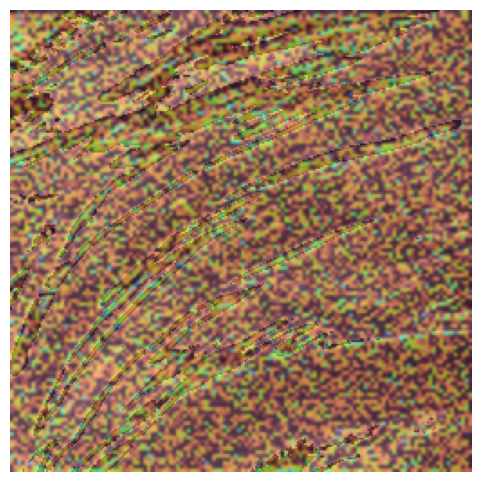

In [16]:
import cv2
from torchcam.methods import SmoothGradCAMpp
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)  # For multi-GPU
np.random.seed(SEED)
random.seed(SEED)

# Use the first convolutional layer for Grad-CAM
target_layer = model.conv_layers[4]  # ✅ Last convolutional layer
cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

# Select a random test image for Grad-CAM
sample_idx = random.randint(0, len(test_dataset) - 1)
sample_image, sample_label = test_dataset[sample_idx]

# Ensure image is in correct shape (add batch dimension)
sample_image = sample_image.unsqueeze(0).to(device)

# Forward pass to get model predictions
output = model(sample_image)  # Raw logits

# Compute Grad-CAM activation map (Fix: Use dict format for targets)
activation_map = cam_extractor([0], output)

# Normalize activation map
# Convert heatmap to NumPy and normalize
heatmap = activation_map[0].squeeze().cpu().detach().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize [0,1]

# Apply a more striking colormap (TURBO or INFERNO)
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_TURBO)

# Convert to PIL Image
original_img = to_pil_image(sample_image.squeeze().cpu().detach())  # Convert test image to PIL
original_img_np = np.array(original_img.convert("RGB"))  # Ensure it's RGB

# Resize heatmap to match the original image dimensions
heatmap_colored = cv2.resize(heatmap_colored, (original_img_np.shape[1], original_img_np.shape[0]))

# Blend Grad-CAM heatmap with the original image (increase `alpha` for emphasis)
alpha = 0.7  # Opacity of heatmap
overlay = cv2.addWeighted(original_img_np, 1 - alpha, heatmap_colored, alpha, 0)

# Display the final result
plt.figure(figsize=(8, 6))
plt.imshow(overlay)
#plt.title(f"Enhanced Grad-CAM (Last Conv Layer) for Loan Delinquency Ratio Prediction")
plt.axis("off")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DL in Banking Book/Images/C2_SmoothGradCam.pdf')
plt.show()

## Interpreting the Grad-CAM Visualization

This heatmap highlights **which areas in the LiDAR image** had the most influence on the model's **loan delinquency prediction**.

---

### What This Image Represents
- **Bright/Warmer Regions (Yellow/Green/Red)** → Areas the model focused on **most** when making its prediction.  
- **Darker Regions (Purple/Black)** → Areas that had little or no impact on the prediction.  




## Training a ResNet-50 for Loan Delinquency Prediction

In this section, use a pretrained ResNet-50, a deep convolutional neural network known for its residual connections that help mitigate vanishing gradients in very deep architectures. Originally trained on ImageNet for image classification, ResNet-50 is adapted here for a regression task on LiDAR imagery.

---

 Specifically, we replace the first convolutional layer to accept grayscale (1-channel) input, and modify the final fully connected layer to output a single continuous value representing the predicted loan delinquency ratio.



In [18]:
import torchvision.models as models
import torch.nn as nn

class ResNet50Regressor(nn.Module):
    def __init__(self, grayscale=False):
        super(ResNet50Regressor, self).__init__()

        # Load pretrained ResNet-50
        self.backbone = models.resnet50(weights='DEFAULT')

        # Adapt input layer for grayscale if needed
        if grayscale:
            self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace final fully connected layer with regression output
        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)   # Output is a scalar
        )

    def forward(self, x):
        return self.backbone(x)


To leverage pretrained features while allowing task-specific learning, we freeze all model parameters except the first convolutional layer (adapted for grayscale), the final residual block (layer4), and the regression head.

In [19]:
input_channels = 1 if train_dataset[0][0].shape[0] == 1 else 3
use_grayscale = input_channels == 1

model = ResNet50Regressor(grayscale=use_grayscale).to(device)

# Freeze all
for param in model.backbone.parameters():
    param.requires_grad = False


# Unfreeze your custom conv1
for param in model.backbone.conv1.parameters():
    param.requires_grad = True

# Unfreeze last residual block and head
for param in model.backbone.layer4.parameters():
    param.requires_grad = True
for param in model.backbone.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


Let's take a look at the model architecture.

In [20]:
print(model)

ResNet50Regressor(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

Now we are ready to train the model.

In [21]:
criterion = nn.MSELoss()  # Or L1Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Let's train the ResNet-50 regression model over 20 epochs using Mean Squared Error (MSE) as the loss function. The training and validation MSE are logged and visualized using LiveLossPlot. The best-performing model (based on validation loss) is saved during training.

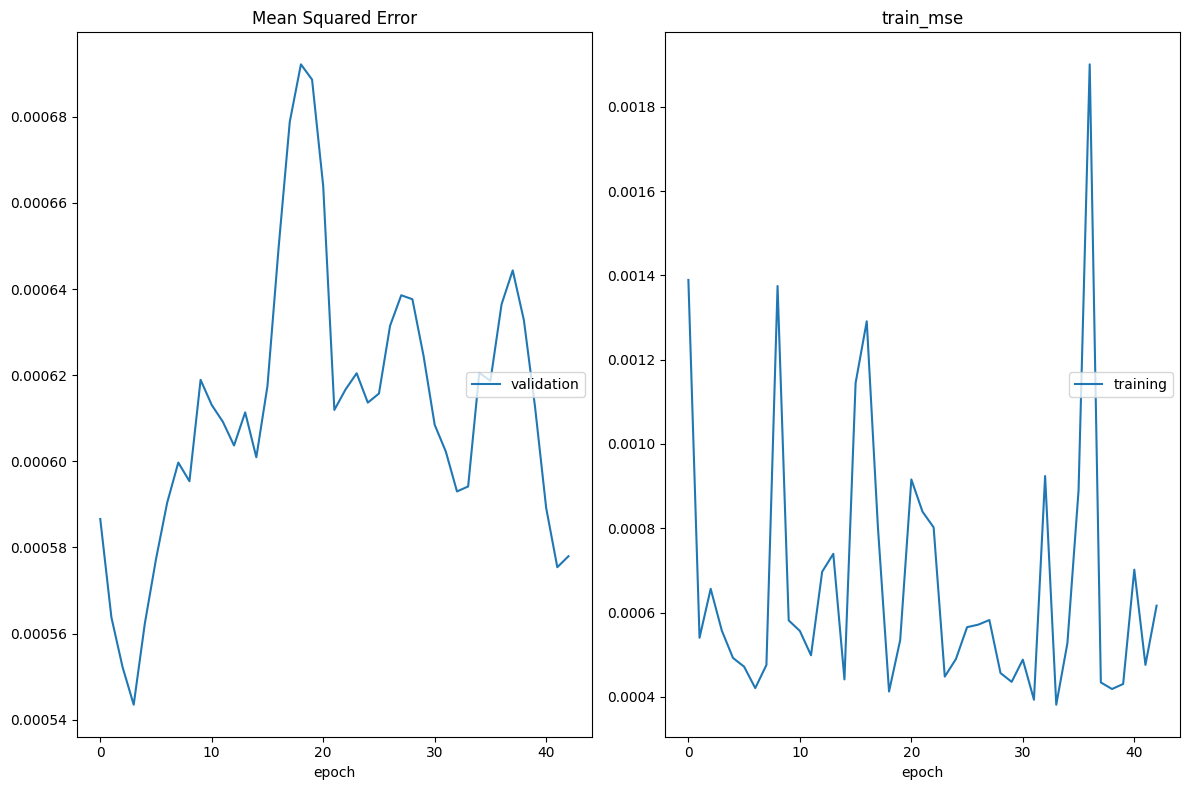

Mean Squared Error
	validation       	 (min:    0.001, max:    0.001, cur:    0.001)
train_mse
	training         	 (min:    0.000, max:    0.002, cur:    0.001)


KeyboardInterrupt: 

In [25]:
# Training with Live Loss Plot
liveloss = PlotLosses()
EPOCHS = 150
best_vloss = float("inf")
model_path = "/content/drive/MyDrive/Colab Notebooks/DL in Banking Book/DeepLearningInBankingBook/TextBook_Lab/c2_best_ResNet50.pth"

# === Training Loop ===
for epoch in range(EPOCHS):
    logs = {}

    # Training Phase
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    logs["train_mse"] = epoch_loss

    # Validation Phase
    model.eval()  # Ensure model is in eval mode
    running_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    val_loss = running_loss / len(val_loader.dataset)


    logs["val_mse"] = val_loss

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {epoch_loss:.4f} "
          f"Val Loss: {val_loss:.4f}")

    # Save Best Model
    if val_loss < best_vloss:
        best_vloss = val_loss
        print(f"New best model saved as {model_path}")
        torch.save(model.state_dict(), model_path)

    # Update Live Loss Plot
    liveloss.update(logs)
    liveloss.send()

print("Training Complete. Best Model Saved.")

After training, we can evaluated the model on the test set using Root Mean Squared Error (RMSE) as the performance metric.

In [26]:
from sklearn.metrics import mean_squared_error

# Load the best model
model.load_state_dict(torch.load(model_path))

# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).squeeze(1)
        outputs = torch.clamp(outputs, min=0.0, max=1.0)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        test_predictions = np.append(test_predictions, outputs.cpu().numpy())

        running_loss += loss.detach() * inputs.size(0)

rmse = mean_squared_error(test_labels, test_predictions)

print(f"Test RMSE: {rmse ** 0.5:.4f}")

Test RMSE: 0.0480


We observe that the test RMSE of ResNet-50 is higher than that of the Simple CNN. This may be due to ResNet-50's large capacity (~25 million parameters), which makes it prone to overfitting on small or low-variance datasets. Additionally, ResNet-50 is pretrained on ImageNet RGB images, whereas our input consists of grayscale LiDAR data. Although the first convolutional layer was modified to accept single-channel input, the pretrained filters in earlier layers may not transfer effectively to this domain.